In [1]:
import pandas as pd
import numpy as np
import time
import torchvision
from torchvision import models
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
import torch.optim as optim
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import random
import cv2
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from imgaug import augmenters as iaa
from skimage import io, transform

print(os.listdir("input"))

['test.csv', 'resized', 'sample_submission.csv', 'train_images.zip', 'test_images.zip', '.ipynb_checkpoints', 'train.csv', 'test_images', 'train_images']


## Define class and functions

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

     
class MyEyeDataset(Dataset):

    def __init__(self, dataframe, training=True, transform=None, sigmax=10):
        self.df = dataframe
        self.transform = transform
        self.training = training
        self.sigmax = sigmax
    
    def __len__(self):
        return len(self.df)
   
    def __getitem__(self, idx):
        if self.training:
            img_name = os.path.join(input_dir, 'train_images', self.df.loc[idx, 'id_code'] + '.png')
        else:    
            img_name = os.path.join(input_dir, 'test_images', self.df.loc[idx, 'id_code'] + '.png')
            
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # keep the green channel only
        #image[:,:,0] = 0
        #image[:,:,2] = 0
        image = crop_image_from_gray(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        #image = cv2.equalizeHist(image)
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        #image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), self.sigmax), -4, 128)
      
        
        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.df.loc[idx, 'diagnosis'])
        
        return image, label

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0

    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                print('lr:', scheduler.get_lr()[0]) 
                dataloader = train_loader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            
            tk0 = tqdm(dataloader, total=int(len(dataloader)))
            # Iterate over data.
            for inputs, labels in tk0:
                labels = labels.view(-1, 1) 
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                   

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            
            epoch_loss = running_loss / len(dataloader)
            
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Constants

In [3]:
input_dir = 'input'

num_classes = 1
seed_everything(24)
lr          = 1e-3
IMG_SIZE    = 224
BS = 16

model_name = "model/reformat.bin"





In [4]:
train      = 'input/train_images/'
test       = 'input/test_images/'
train_csv  = pd.read_csv('input/train.csv')
sample = pd.read_csv('input/sample_submission.csv')



train_df, val_df = train_test_split(train_csv, test_size=0.15, random_state=98)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)


In [5]:
trn_tsfm = transforms.Compose([   
                           transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
                           transforms.Grayscale(num_output_channels=3),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomVerticalFlip(),
                           transforms.ColorJitter(brightness=[1.0,1.1],contrast=[2.0,2.5]),
                           transforms.ToTensor(),
                           #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              ])

test_tsfm = transforms.Compose([
                           transforms.Grayscale(num_output_channels=3),
                           transforms.RandomResizedCrop(IMG_SIZE, scale=(1.0, 1.0)),
                           transforms.ColorJitter(brightness=[1.0,1.1],contrast=[2.0,2.5]),
                           transforms.ToTensor(),
                           #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              ])

train_set = MyEyeDataset(train_df, transform = trn_tsfm, training=True, sigmax=10)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True, num_workers=4)

val_set       = MyEyeDataset(val_df, transform = trn_tsfm, training=True, sigmax=10)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=BS, shuffle=False, num_workers=4)

test_set       = MyEyeDataset(sample, transform = test_tsfm, training=False, sigmax=10)
test_loader   = torch.utils.data.DataLoader(test_set, batch_size=BS, shuffle=False, num_workers=4)






## Visualise a few images

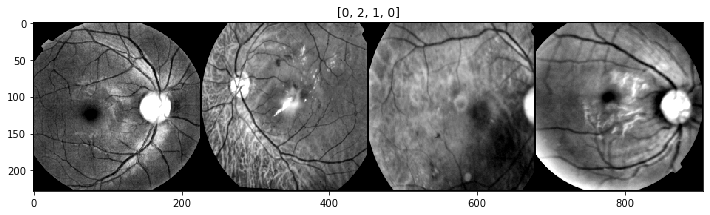

In [6]:
# fig=plt.figure(figsize=(8, 8))
# columns = 3
# rows = 3
# for i in range(1, columns*rows +1):
#     inputs, labels =  next(iter(val_set))
#     img = inputs.permute(1, 2, 0)
#     fig.add_subplot(rows, columns, i)
#     #label = labels.detach().cpu().squeeze().numpy().reshape(-1, 1)[0][0]
#     #plt.title(label)
#     plt.imshow(img)
# plt.show()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(12,12))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
example_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)


class_names = [0,1,2,3,4]
# Get a batch of training data
inputs, classes = next(iter(example_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

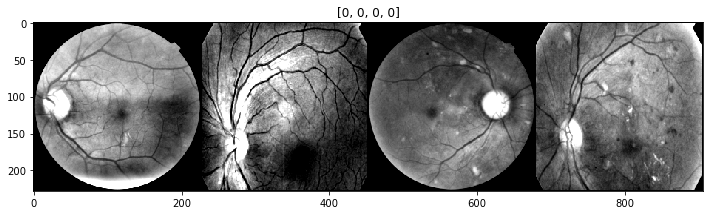

In [7]:
# fig=plt.figure(figsize=(8, 8))
# columns = 3
# rows = 3
# for i in range(1, columns*rows +1):
#     inputs, labels =  next(iter(val_set))
#     img = inputs.permute(1, 2, 0)
#     fig.add_subplot(rows, columns, i)
#     #label = labels.detach().cpu().squeeze().numpy().reshape(-1, 1)[0][0]
#     #plt.title(label)
#     plt.imshow(img)
# plt.show()

def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(12,12))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
example_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=4)

class_names = [0,1,2,3,4]
# Get a batch of training data
inputs, classes = next(iter(example_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Define Model

In [8]:
device = torch.device("cuda:0")
torch.cuda.is_available()


model = models.resnet101(pretrained=True)
model.fc = nn.Sequential(
                          nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                          nn.Dropout(p=0.25),
                          nn.Linear(in_features=2048, out_features=2048, bias=True),
                          nn.ReLU(),
                          nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                          nn.Dropout(p=0.5),
                          nn.Linear(in_features=2048, out_features=1, bias=True),
                         )
model.avg_pool = nn.AdaptiveAvgPool2d(1)
model.cuda()




ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

### Loss function and optimizor

In [9]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=10)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


### Training

In [10]:
model_ft = train_model(model, criterion, optimizer, scheduler,
                       num_epochs=25)

torch.save(model_ft.state_dict(), model_name)



Epoch 0/24
----------
lr: 0.001



train Loss: 18.4236



val Loss: 18.3737
Epoch 1/24
----------
lr: 0.001



train Loss: 9.9148



val Loss: 16.3033
Epoch 2/24
----------
lr: 0.001



train Loss: 9.7260



val Loss: 9.6100
Epoch 3/24
----------
lr: 0.001



train Loss: 10.0228



val Loss: 7.8646
Epoch 4/24
----------
lr: 0.001



train Loss: 8.3470



val Loss: 5.5024
Epoch 5/24
----------
lr: 1e-05



train Loss: 8.2973



val Loss: 5.5707
Epoch 6/24
----------
lr: 0.0001



train Loss: 8.0125



val Loss: 5.5412
Epoch 7/24
----------
lr: 0.0001



train Loss: 7.5943



val Loss: 5.1583
Epoch 8/24
----------
lr: 0.0001



train Loss: 7.1238



val Loss: 5.1439
Epoch 9/24
----------
lr: 0.0001



train Loss: 7.0971



val Loss: 5.1529
Epoch 10/24
----------
lr: 1.0000000000000002e-06



train Loss: 6.5445



val Loss: 5.5974
Epoch 11/24
----------
lr: 1e-05



train Loss: 6.6954



val Loss: 5.0140
Epoch 12/24
----------
lr: 1e-05



train Loss: 7.1185



val Loss: 5.1478
Epoch 13/24
----------
lr: 1e-05



train Loss: 6.4813



val Loss: 5.2531
Epoch 14/24
----------
lr: 1e-05



train Loss: 6.9195



val Loss: 5.1117
Epoch 15/24
----------
lr: 1.0000000000000002e-07



train Loss: 7.2928



val Loss: 5.4456
Epoch 16/24
----------
lr: 1.0000000000000002e-06



train Loss: 7.2543



val Loss: 5.0071
Epoch 17/24
----------
lr: 1.0000000000000002e-06



train Loss: 6.8073



val Loss: 5.2269
Epoch 18/24
----------
lr: 1.0000000000000002e-06



train Loss: 6.7936



val Loss: 5.2608
Epoch 19/24
----------
lr: 1.0000000000000002e-06



train Loss: 6.8415



val Loss: 5.3041
Epoch 20/24
----------
lr: 1.0000000000000004e-08



train Loss: 7.0993



val Loss: 5.2449
Epoch 21/24
----------
lr: 1.0000000000000002e-07



train Loss: 7.0767



val Loss: 5.1392
Epoch 22/24
----------
lr: 1.0000000000000002e-07



train Loss: 7.2881



val Loss: 5.6391
Epoch 23/24
----------
lr: 1.0000000000000002e-07



train Loss: 7.1084



val Loss: 5.4830
Epoch 24/24
----------
lr: 1.0000000000000002e-07



train Loss: 6.7070



val Loss: 5.4174
Training complete in 49m 53s
Best val loss: 5.007097


## Validation Kappa Score

In [11]:
from sklearn import metrics


val_pred = np.zeros((len(val_df), 1))


for i, data in tqdm(enumerate(val_loader)):
    images, labels = data
    images = images.to(device, dtype=torch.float)
    outputs = model(images) 
    val_pred[i * BS:(i + 1) * BS] += outputs.detach().cpu().squeeze().numpy().reshape(-1, 1)


coef = [0.5, 1.5, 2.5, 3.5]

for i, pred in enumerate(val_pred):
    if pred < coef[0]:
        val_pred[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        val_pred[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        val_pred[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        val_pred[i] = 3
    else:
        val_pred[i] = 4
        
val_df['pred'] = val_pred

metrics.cohen_kappa_score(val_df['diagnosis'], val_df['pred'], weights='quadratic')

/home/qile/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.8795950013682386

In [12]:
val_df

,id_code,diagnosis,pred
0,1b32e1d775ea,4,3.0
1,de16416220de,4,3.0
2,0af296d2f04a,2,2.0
3,75a071608ea6,0,0.0
4,d83c3efade75,2,2.0
5,1a90fad9ffa2,4,2.0
6,02cd34a85b24,0,0.0
7,87b671c6d4c5,0,0.0
8,a5bb85afc6e8,0,0.0
9,962c0fc85e13,0,0.0
